# 11. 반복 서치
- 그리드 서치가 미리 정의된 후보 값 세트를 가져와 평가한 다음, 최상의 파라미터를 선택한다면, 
    **반복 서치는 서치 절차 중에 다음에 테스트할 값을 예측**

- 베이즈 최적화는 기존 리샘플링 결과에 대해 훈련된 예측 모델을 사용하여, 튜닝 파라미터 값을 제안하는 반면, 
    
    시뮬레이션 어닐링은 파라미터 공간을 탐색하여 좋은 값을 탐색. 
- 둘 다 좋은 파라미터 값을 찾는 데 단독으로 사용하거나,
    
    성능을 더욱 미세 조정하기 위해 초기 그리드 검색 후에 사용되는 후속 방법으로 효과적

In [3]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()
library(ggforce)

In [4]:
data(cells)
cells <- cells %>% select(-case)

set.seed(1304)
cell_folds <- vfold_cv(cells)

roc_res <- metric_set(roc_auc)

<br>

## 11.01. SVM
- 최적화할 두 가지 파라미터는 SVM Cost 값과, $\sigma$ (radial basis function kernel parameter)
- 두 파라미터 모두 모델의 복잡성과 성능에 큰 영향을 미침



<br>

- 전처리 정의

In [5]:
svm_rec <- recipe(class ~ ., data = cells) %>%
    step_YeoJohnson(all_numeric_predictors()) %>%
    step_normalize(all_numeric_predictors())

- 모델 정의

In [6]:
svm_spec <- svm_rbf(cost = tune(), rbf_sigma = tune()) %>% 
    set_engine("kernlab") %>% 
    set_mode("classification")

- 워크플로 정의

In [7]:
svm_wflow <- workflow() %>% 
    add_model(svm_spec) %>% 
    add_recipe(svm_rec)

- 두 튜닝 파라미터 ```cost``` 및 ```rbf_sigma```에 대한 기본 매개 변수 범위

In [8]:
cost()

Cost (quantitative)
Transformer: log-2 [1e-100, Inf]
Range (transformed scale): [-10, 5]

In [9]:
rbf_sigma()

Radial Basis Function sigma (quantitative)
Transformer: log-10 [1e-100, Inf]
Range (transformed scale): [-10, 0]

- 커널 파라미터 범위를 약간 변경

In [10]:
svm_param <- svm_wflow %>% 
    extract_parameter_set_dials() %>% 
    update(rbf_sigma = rbf_sigma(c(-7, -1)))

In [13]:
svm_param %>% extract_parameter_dials("cost")
svm_param %>% extract_parameter_dials("rbf_sigma")

Cost (quantitative)
Transformer: log-2 [1e-100, Inf]
Range (transformed scale): [-10, 5]

Radial Basis Function sigma (quantitative)
Transformer: log-10 [1e-100, Inf]
Range (transformed scale): [-7, -1]

<br>

#### SVM의 튜닝 파라미터와 AUC
- 2,500 개의 후보 값으로 구성된 매우 큰 정규 그리드를 구성하고, 리샘플링을 사용하여 그리드를 평가했다고 할 때 
- 밝은 색상일수록 높은 모델 성능을 의미하는 아래의 그림에서, 파라미터 공간의 아래쪽 대각선에는 성증이 좋지 않아 상대적으로 평탄한 넓은 범위가 존재
- 최고의 성능을 보이는 능선은 공간의 오른쪽 상단에 위치하며, 검은색 점은 최적의 파라미터 조합을 의미

- **성능이 낮은 영역에서, 최고의 성능을 보이는 능선으로의 전환은 매우 급격함을 알 수 있으며**
    
    **능선 오른쪽에도 급격한 성능 하락구간이 존재**

<img src = 'https://www.tmwr.org/premade/roc_surface.png'>

<br>

- **반복 서치 절차를 진행하려면, 초기 성능 통계량이 필요**
    
    $\rightarrow$ 파라미터 공간의 평평한 부분에 있는 작은, 초기 정규 그리드를 생성

In [14]:
set.seed(1401)
start_grid <- svm_param %>% 
    update(
        cost = cost(c(-6, 1)),
        rbf_sigma = rbf_sigma(c(-6, -4))
    ) %>% 
    grid_regular(levels = 2)

In [15]:
set.seed(1402)
svm_initial <- svm_wflow %>% 
    tune_grid(resamples = cell_folds, grid = start_grid, metrics = roc_res)

- 초기 그리드에서의 성능은 그다지 높지 않음을 확인
    
- 이러한 결과는 반복 튜닝 기능을 통해 수집되어 초기 값으로 사용될 수 있음

In [16]:
collect_metrics(svm_initial)

cost,rbf_sigma,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.015625,1e-06,roc_auc,binary,0.8638724,10,0.008637894,Preprocessor1_Model1
2.000000,1e-06,roc_auc,binary,0.8625326,10,0.008672545,Preprocessor1_Model2
0.015625,1e-04,roc_auc,binary,0.8627495,10,0.008624554,Preprocessor1_Model3
2.000000,1e-04,roc_auc,binary,0.8659439,10,0.008545691,Preprocessor1_Model4


<br>

## 11.02. 베이지안 최적화
- 베이지안 최적화는 현재 리샘플링 결과를 분석하고, 예측 모델을 생성하여 아직 평가되지 않은 튜닝 파라미터 값을 제안
    
    $\rightarrow$ 제안된 파라미터 조합이 다시 샘플링
    
    $\rightarrow$ 이러한 결과는 테스트를 위해 더 많은 후보 값을 추천하는 또 다른 예측 모델에 사용
    
- 이 절차는 설정된 반복 횟수 동안 또는 더 이상 개선이 이루어지지 않을 때까지 진행 (Shahriariet al. ( 2016 ) 및 Frazier ( 2018 ))
- 베이지안 최적화를 사용할 때 주요 관심사는 모델을 생성하는 방법과, 해당 모델에서 권장하는 파라미터를 선택하는 방법
    

<br>

### 가우시안 프로세스 모델 (Gaussian Process)
- **가우시안 프로세스(GP) 모델은 공간 통계(크리깅)에 역사가 있는 잘 알려진 통계 기법**
- 베이지안 모델을 포함하여 여러 가지 방법으로 도출 가능

<br>

- **수학적으로 GP는, 결합 확률 분포가 다변량 정규분포인 확률 변수의 집합**
    
    파라미터 튜닝의 맥락에서 이는, 후보 값에 대한 성능 지표의 모음
- **이전 4개 표본의 초기 그리드의 경우, 이들 4개 확률 변수의 성능은 각각 0.8639, 0.8625, 0.8627, 0.8659였고. 이것들이 다변량 정규분포를 따른다고 가정**





<br>

- GP 모델의 초기 값으로 사용되는 리샘플링 통계량
    - GP모델에서 설명변수는 파라미터의 조합, 반응변수는 성능 지표


In [17]:
collect_metrics(svm_initial) %>% 
    select(ROC = mean, cost, rbf_sigma) %>% 
    as.data.frame()

ROC,cost,rbf_sigma
<dbl>,<dbl>,<dbl>
0.8638724,0.015625,1e-06
0.8625326,2.000000,1e-06
0.8627495,0.015625,1e-04
0.8659439,2.000000,1e-04


<br>

- **가우시안 프로세스 모델은 평균 및 공분산 함수에 의해 구성되지만, 공분산 함수가 GP 모델의 특성에 가장 큰 영향을 미침**
    - **공분산 함수는 종종 입력 값($x$)의 측면에서 파라미터가 될 수 있음**
    - 예) 일반적으로 사용되는 공분산 제곱-지수 형태

$$\operatorname{cov}(\boldsymbol{x}_i, \boldsymbol{x}_j) = \exp\left(-\frac{1}{2}|\boldsymbol{x}_i - \boldsymbol{x}_j|^2\right) + \sigma^2_{ij}$$

- $\sigma_{ij}^2$는 $i = j$일 때 0인, 오차 분산 항. 
    - 이 방정식은 다음과 같이 해석 :
> 두 튜닝 파라미터 조합 간의 거리가 증가함에 따라, 성능 지표간의 공분산은 기하급수적으로 증가
>
> 또는 $|x_i - x_j|^2$가 0일 때 공분산은 최소화

<br>

- **이러한 공분산 함수의 특성으로 인해 가우시안 프로세스는 적은 양의 데이터만 존재하는 경우에도, 모델 성능과 튜닝 파라미터 사이의 매우 비선형적인 관계를 나타낼 수 있음**
    - 그러나 이러한 모델을 적합하는 것은 경우에 따라 어려울 수 있으며, 모델은 튜닝 파라미터 조합의 수가 증가함에 따라 계산 비용이 더 많이 듬

<br>

- 이 모델의 장점은 새로운 입력값에 대한 예측이, 결과의 전체 분포를 반영할 수 있다는 것. 
    
    다시 말해, **새로운 성능 통계량은 평균과 분산의 관점에서 모두 예측될 수 있음**











<br>

#### 두 개의 튜닝 파라미터가 존재하는 예시
- A는 B보다 약간 더 나은 평균 성능 (ROC)값을 가지지만, 분산은 B보다 4배 더 큼
- A를 선택하는 것은 더 위험하지만, 잠재적으로 더 높은 이익을 얻을 수 있음
    
    또한, 분산의 증가는 새로운 입력값이 B보다 기존 데이터에서 더 멀다는 것을 반영

- 초기 그리드를 바탕으로 GP 모델이 적합되고, 후보가 선정됨
    
    $\rightarrow$ 다음 튜닝 파라미터 조합이 선택
    
    $\rightarrow$ 새로운 조합에 대한 성능 추정치를 계산하고, GP 모델은 5개의 결과로 다시 조정

<br>

### 획득 기능
- **본질적인 목표는, 현재의 최고값보다 더 나은 결과를 얻을 가능성이 높은 다음 튜닝 파라미터 조합을 선택하는 것**
- **이를 위한 방식은, 대규모 후보 조합을 생성한 다음, 각각에 대해 평균 및 분산 예측을 수행**
    
    $\rightarrow$ **이 정보를 이용하여, 가장 유리한 튜닝 파라미터값을 선택**
    
<br>

- 획득 함수라고 불리는 목적 함수 객체는, 평균과 분산 간의 균형을 용이하게 하며,
    
    **GP모델의 예측값의 분산은 대부분 기존 데이터에서 얼마나 멀리 떨어져 있는지에 따라 결정**
- **새로운 후보값에 대한 예측값의 평균과 분산 사이의 균형은 'Exploration'와 'Exploitation'을 통해 진행**
    - **Exploration** : 후보지가 더 적은 영역으로 선택을 편향. 이는 분산이 더 높은 후보지에게 더 많은 가중을 두고, 새로운 결과를 찾는 데 초점을 맞추는 경향
    - **Exploitation** : 주로 평균 예측에 의존하여, 최상의 평균 값을 탐색. 기존의 결과에 가중을 둠

<br>

#### [0, 1] 사이의 값을 단일 파라미터가 있는 예재
- $R^2$가 성능 지표일 때, 임의의 튜닝 파라미터에 따른 $R^2$의 변동이 아래와 같을 때, 
    - 점은 관측값 (실제 $R^2$가 평가된 파라미터 지점)

<img src='https://www.tmwr.org/figures/performance-profile-1.png'>

- GP모델 적합에 따른 $R^2$의 예측값
    - 음영부분의 신뢰구간은 제곱-지수 분산 함수이며, 각 관측값 사이에서 매우 커지며, 각 관측값에서 0으로 수렴
        
    - 두 개의 수직 점선은 다음에 더 자세히 조사할 두 개의 후보 지점
- **이러한 GP모델 예측값의 비선형 추세는, 실제 $R^2$의 변동과 일치하지 않지만,**
    
    **최적의 파라미터 지점에 대해서 올바른 방향을 제시해줄 수 있음**
    
    - **GP모델의 예측값에서, 가장 높은 $R^2$값을 가지는 지점은 0.106**

        **$\rightarrow$ 실제 관측값 중 가장 높은 $R^2$값을 가지는 0.09의 근처**

<img src ='https://www.tmwr.org/figures/estimated-profile-1.png'>

<br>

- 추가적인 접근방식은 가장 큰 신뢰 구간과 관련된 조정 매개변수를 탐색
- $R^2$의 신뢰구간을 위한 표준 편차를 1개로 정의하는 것 (=$\mu \pm 1\sigma_{R^2}$)보다, 
    
    **2개로 정의하는 것(=$\mu \pm \sigma_{R^2}$)이 다음 후보지 선택이 후보지가 적은 영역 (관측값들과의 거리가 먼 지점)에서 진행될 가능성이 높아짐**

<br>

#### 기대 개선 (Expected Improvement)
- **신용구간 접근방식과는 달리, 현재 최상의 결과값이 필요**
- **GP는 분포를 사용하여 새로운 후보 지점을 특정할 수 있으므로, 성능 개선이 발생할 확률을 사용하여, 개선을 나타내는 분포 부분에 가중치를 부여**
- 위의 그래프에서 수직 점선이 지나는 후보 지점인 0.1과 0.25에서의 $R^2$값의 분포
    - 분포의 평균만 고려한다면 0.1이 더 좋은 선택,
        
        **하지만 0.25에 따른 $R^2$분포의 분산이 더 넓음**
            
        $\rightarrow$ **기대할 수 있는 성능의 개선 범위가 더 넓음**
    
<img src = 'https://www.tmwr.org/figures/two-candidates-1.png'>

<thead>
<tr>
<th style="empty-cells: hide;border-bottom:hidden;" colspan="1">
</th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; " colspan="3">
<div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">
Predictions
</div>
</th>
</tr>
<tr>
<th style="text-align:left;">
Parameter Value
</th>
<th style="text-align:left;">
평균
</th>
<th style="text-align:left;">
표준편차
</th>
<th style="text-align:left;">
기대 개선
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
0.10
</td>
<td style="text-align:left;">
0.8679
</td>
<td style="text-align:left;">
0.0004317
</td>
<td style="text-align:left;">
0.000190
</td>
</tr>
<tr>
<td style="text-align:left;">
0.25
</td>
<td style="text-align:left;">
0.8671
</td>
<td style="text-align:left;">
0.0039301
</td>
<td style="text-align:left;">
0.001216
</td>
</tr>
</tbody>
</table>

- 기대개선이 튜닝 파라미터 범위 전체에 걸쳐 계산될 때, 가장 높은 성능을 기대할 수 있는 파라미터 지점은 0.25

<img src = 'https://www.tmwr.org/figures/expected-improvement-1.png'>

<br>

#### `tune_bayes()` : 베이지안 최적화를 통해 반복 서치를 구현
- **`iter`** : 최대 반복 횟수
- **`initial`** : 
    - 정수입력시 '공간 채우기 설계'의 크기
    - `tune_grid()`, racing method 와 같은 튜닝 설정 객체 입력 가능
-  **`objective`** : 획득함수 (`exp_improve()`, `conf_bound()` 등)
- **`param_info`** : 파라미터의 범위 지정
- **`control`** : 튜닝 설정
    - **`control_bayes()`객체 입력**
        - `no_improve`: 특정 횟수의 반복 내에서 개선된 파라미터가 발견되지 않으면 검색을 중지
        - `uncertain` : 특정 횟수의 반복 내에서 개선이 없으면 불확실성 샘플을 추출하며, 다음 파라미터 선택을 순수하게 분산의 크기가 큰 것으로 결정 (순수한 파라미터 공간 탐색의 효과)
    
<br>

#### SVM에 대한 베이지안 최적화

In [20]:
ctrl <- control_bayes(verbose = F)

In [21]:
set.seed(1403)
svm_bo <- svm_wflow %>%
    tune_bayes(
        resamples = cell_folds,
        metrics = roc_res,
        initial = svm_initial,
        param_info = svm_param,
        iter = 25, 
        control = ctrl
    )

In [25]:
show_best(svm_bo)

cost,rbf_sigma,.metric,.estimator,mean,n,std_err,.config,.iter
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
24.69257,0.001862566,roc_auc,binary,0.8986889,10,0.007831216,Iter24,24
31.68604,0.001840954,roc_auc,binary,0.8985910,10,0.007877104,Iter19,19
24.20870,0.001953214,roc_auc,binary,0.8985701,10,0.007849007,Iter20,20
31.76870,0.001539922,roc_auc,binary,0.8985230,10,0.007847247,Iter18,18
13.29537,0.002882753,roc_auc,binary,0.8984508,10,0.008110663,Iter17,17


<br>

- **반복 서치 이전의 초기 성능 통계량에서 반복(iteration)을 반복할수록 성능 통계량이 증가함을 확인**

In [35]:
show_best(svm_initial)

cost,rbf_sigma,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2.000000,1e-04,roc_auc,binary,0.8659439,10,0.008545691,Preprocessor1_Model4
0.015625,1e-06,roc_auc,binary,0.8638724,10,0.008637894,Preprocessor1_Model1
0.015625,1e-04,roc_auc,binary,0.8627495,10,0.008624554,Preprocessor1_Model3
2.000000,1e-06,roc_auc,binary,0.8625326,10,0.008672545,Preprocessor1_Model2


- 6번째 반복에서 가장 높은 성능

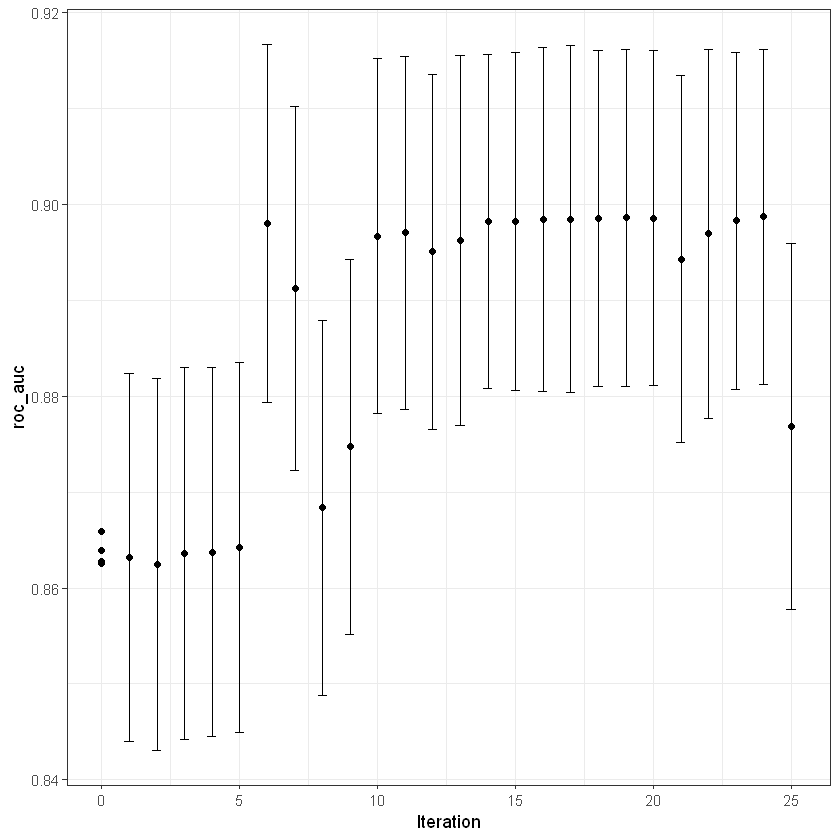

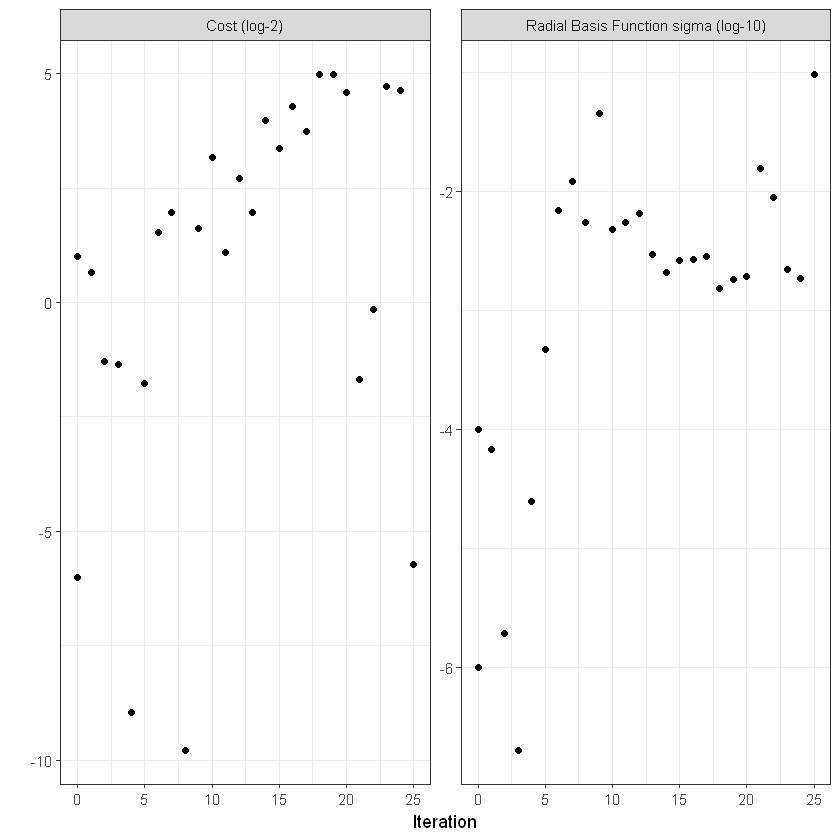

In [36]:
autoplot(svm_bo, type="performance")
autoplot(svm_bo, type="parameter")

- 베이지안 최적화 과정에 대한 시각화

https://www.tmwr.org/bo_search.mp4

<br>

## 11.03. 시뮬레이션 어닐링 (Simulation Annealing, SA)
- 시뮬레이션된 어닐링 (SA) ( Kirkpatrick, Gelatt, and Vecchi 1983 ; Van Laarhoven and Aarts 1987 ) 은 금속이 냉각되는 과정에서 영감을 받은 일반적인 비선형 서친 루틴
- 불연속적인 기능을 포함하여 다양한 유형의 환경을 효과적으로 탐색할 수 있는 전역 서치 방법

<br>

### 시뮬레이션 어닐링 과정
- **시뮬레이션 어닐링을 사용하는 프로세스는 초기 값으로 시작하여, 파라미터 공간을 통해 제어된 무작위 이동을 시작**
- **각각의 새로운 후보 파라미터 값은, 이전 파라미터값의 근방에 위치**

- 후보 파라미터 값에 대하여 성능값을 계산하기 위해서 리샘플링 진행
    
    $\rightarrow$ 이전 파라미터 값보다 더 나은 결과를 얻으면 새로운 최적값으로 수용되고 프로세스가 지속
    
    $\rightarrow$ 결과가 이전 파라미터 값보다 나쁜 경우 서치 절차는 계속해서 이 값을 사용하여 추가 단계를 진행

<br>

- **시뮬레이션 어닐링의 두 가지 요인**
    - 성능이 나빠질수록 나쁜 결과를 받아들일 가능성이 감소
        
        **즉, 최악의 결과가 방지되어 차악의 결과가 도출**
    - 반복 횟수 : **시뮬레이션 어닐링은 서치가 진행됨에 따라, 차선의 값을 수용**
    
    $\rightarrow$ **위 두 가지 요소를 통하여, 결과 수용에 대한 확률은 다음과 같이 공식화**

<br>

$$\operatorname{Pr}[\text{$i$번째 반복을 통하여 차선의 파라미터 값이 수용}] = \exp(c\times D_i \times i)$$

- $i$ : 반복 횟수
- $c$ : 사용자 지정 상수 (통상 0.02). 값이 감소할수록, 서치 결과가 좋지 않은 경우에도 수용할 확률이 증가 (수용 관대함 증가)
* $D_i$ : 이전 파라미터값과, 새로운 파라미터 값 사이의 백분율 차이 (음수가 나올 시, 새로운 결과의 성능이 더 나쁨을 의미)

<br>

**새로운 결과의 성능이 좋지 않은 경우, 수용 확률을 결정하고 이를 임의의 수와 비교**

$\rightarrow$ **임의의 수가 수용 확률 값보다 큰 경우, 서치에서는 새로운 파라미터를 수용하지 않고, 이전 파라미터 값을 지속해서 채택**

<br>

- 사용자 지정 상수 $c$와 반복 횟수$i$, 성능에 따른 수용 확률의 변동
<img src = 'https://www.tmwr.org/figures/acceptance-prob-1.png'>

<br>

- **시뮬레이션 어닐링은 반복 횟수내에서 최상의 결과가 발생하지 않으면 중단됨**
    
    $\rightarrow$ **재시작 임계값 설정** : 일련의 좋지 않은 결과가 있는 경우, 이 기능은 마지막으로 좋은 성능을 보인 파라미터 설정을 초기값으로 삼아 서치를 재시작

- **각 반복마다 튜닝 파라미터를 미세하게 교란 (일반화된 시뮬레이션 어닐링)**
    - 연속형 튜닝 파라미터의 경우, 근접한 이웃을 지정하기 위해 작은 반경을 정의
    
        예) 두 개의 튜닝 파라미터가 있고, 각 매개변수는 0과 1의 범위에서 제한되어 있을 때, 시뮬레이션 어닐링은 주변 반경에 임의의 값을 생성하고, 후보 파라미터 값이 될 값을 무작위로 선택

<br>

#### `glmnet` 예시
- 정규화 페널티 `penalty` :  범위 [$10^{-10}, 10^0$]
- 라소 규제 비율 `mixture`: 범위 [0, 1]

<br>

1. 초기 파라미터 값 설정: `penalty=0.025`, `mixture = 0.050`
2. 0.050과 0.015 사이의 반경과, 반경 내에서의 교란을 통해 파라미터 초기값 주변에 임의이 값의 세트를 생성한 후, 무작위로 하나의 값을 후보값으로 선택
3. 선택된 후보값 주변의 무작위 이웃 세트를 생성하여, 다시 후보값 선택과 세트 생성을 반복
4. 이전에 선택된 값 혹은 그와 유사한 값이 다시 선택되지 않도록 방지

<img src = 'https://www.tmwr.org/figures/iterative-neighborhood-1.png'>

<br>

#### `tune_sim_anneal()` : 시뮬레이션 어닐링을 통한 반복 서치 구현
- **`no_improve`** : 특정 횟수의 반복 내에서 성능이 개선되지 않으면 검색을 중지
- **`restart`** : 특정 횟수의 반복 내에서 성능이 개선되지 않으면, 이전 값을 재시작점으로 삼아 서치 재시작
- **`radius`** : 초기값 근방 이웃의 최소 및 최대 반경
- **`flip`** : 범주형 또는 연속형 파라미터의 값이 변경될 가능성을 정의하는 확률
- **`cooling_coef`** : $\exp(c\times D_i \times i)$에서의 $c$값
    - 반복을 통해 새로운 값의 수용 확률이 얼마나 빨리 감소하는지 조절.
    - 값이 클수록 차선의 파라미터 값을 수용할 확률이 감소

In [41]:
library(finetune)

In [44]:
ctrl_sa <- control_sim_anneal(verbose = F, no_improve = 10L)

In [45]:
set.seed(1404)
svm_sa <- svm_wflow %>%
    tune_sim_anneal(
    resamples = cell_folds,
    metrics = roc_res,
    initial = svm_initial,
    param_info = svm_param,
    iter = 50,
    control = ctrl_sa
    )

Optimizing roc_auc

Initial best: 0.86594

1 ◯ accept suboptimal  roc_auc=0.86351 (+/-0.008642)

2 ♥ new best           roc_auc=0.87334 (+/-0.008402)

3 ◯ accept suboptimal  roc_auc=0.86724 (+/-0.00838)

4 + better suboptimal  roc_auc=0.87042 (+/-0.008147)

5 ♥ new best           roc_auc=0.87444 (+/-0.008459)

6 ◯ accept suboptimal  roc_auc=0.86966 (+/-0.00811)

7 ◯ accept suboptimal  roc_auc=0.86589 (+/-0.008448)

8 ◯ accept suboptimal  roc_auc=0.86233 (+/-0.008657)

9 ◯ accept suboptimal  roc_auc=0.8623 (+/-0.008648)

10 + better suboptimal  roc_auc=0.86232 (+/-0.008658)

11 + better suboptimal  roc_auc=0.86238 (+/-0.008671)

12 + better suboptimal  roc_auc=0.86246 (+/-0.008646)

13 ✖ restart from best  roc_auc=0.86254 (+/-0.008613)

14 ◯ accept suboptimal  roc_auc=0.87261 (+/-0.008351)

15 + better suboptimal  roc_auc=0.8728 (+/-0.008301)

16 ♥ new best           roc_auc=0.88979 (+/-0.00886)

17 ♥ new best           roc_auc=0.89188 (+/-0.008923)

18 ♥ new best           roc_auc=0.89

In [48]:
show_best(svm_sa)

cost,rbf_sigma,.metric,.estimator,mean,n,std_err,.config,.iter
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
10.439221,0.003905738,roc_auc,binary,0.8979963,10,0.008253020,Iter37,37
2.745016,0.007152477,roc_auc,binary,0.8979348,10,0.008392826,Iter18,18
29.992035,0.002323313,roc_auc,binary,0.8978954,10,0.007740899,Iter42,42
19.775365,0.002932892,roc_auc,binary,0.8977000,10,0.007898298,Iter49,49
5.216009,0.003281398,roc_auc,binary,0.8976575,10,0.008244686,Iter36,36


- 27번째 반복에서 가장 높은 성능

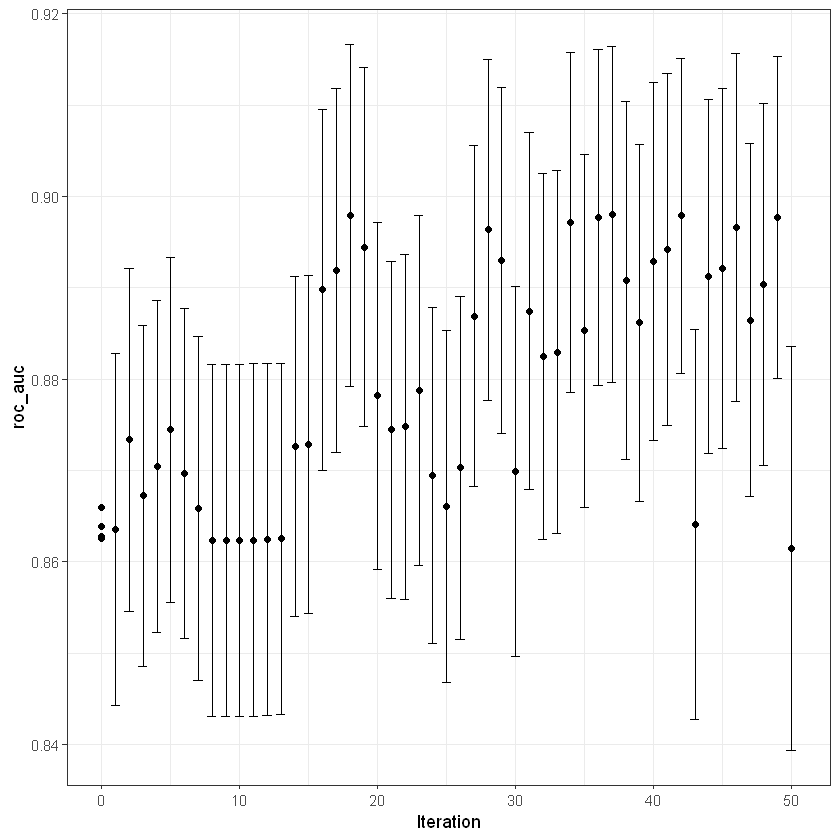

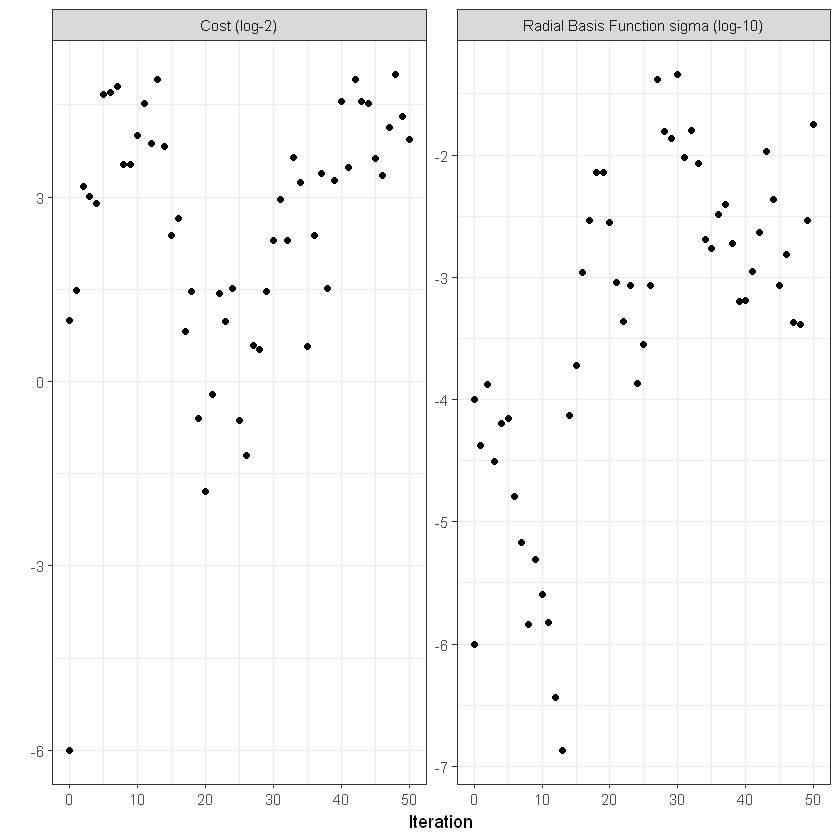

In [46]:
autoplot(svm_sa, type = "performance")
autoplot(svm_sa, type = "parameters")

- 시뮬레이션 어닐링 과정에 대한 시각화

https://www.tmwr.org/sa_search.mp4